## Examples for HiCPAP

This notebook is separated into two parts:

1. Plotting with the intra-chromosomal Hi-C Pearson matrix & Approximated PC1-pattern.
2. (Bonus) How to reproduce the experiments in our paper.

In the 1st part we explain how to create the Approximated pc1-pattern from the intra-chromosomal Hi-C Pearson correlation matrix, which is the main usage of HiCPAP. We use the `GSE63525_GM12878_insitu_primary+replicate_combined_30.hic` provided by [GSE63525](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525) with the [juicer_tools 1.22.01](https://github.com/aidenlab/juicer/wiki/Download) to create the Pearson matrix (GM12878, chromosome 1, resolution 1000000), and illustrate how to plot the Hi-C Pearson matrix with the Approximated PC1-pattern for the A/B compartment analysis.

In the 2nd part we explain how to create the figures for comparing the difference between the PC1 and the Approximated PC1-pattern in our paper. You can skip this part if you're only interested in how to create the Approximated PC1-pattern. 

**Please note that:**

1. HiCPAP returns the Hi-C Pearson matrix, PC1 and Approximated PC1-pattern in the `numpy.ndarray` format.
2. The input Pearson matrix should be `D*D` and symmetric (D: the length of the x or y axis). 
3. The calculation will only be performed on the valid sub-matrix, which means the rows or columns with all `NaN` will be excluded. However these all `NaN` rows or columns will not be removed in the function return, since the `NaN` positions still provide the valuable information in the Hi-C experiments.

For example:

(1) HiC Pearson matrix (4*4, symmetric).
>```py
>[
>    [1,   NaN, NaN, 0.2],
>    [NaN, NaN, NaN, NaN],
>    [NaN, NaN, NaN, NaN],
>    [0.2, NaN, NaN,   1],
>]
>```

(2) Only the valid sub-matrix will be calculated. For example:

>a. Extract the valid sub-matrix. 
>```py
>[
>    [1,   0.2],
>    [0.2,   1],
>]
>```
>
>b. Calculated the covariance of the valid sub-matrix with `np.cov(bias=True)`.
>```py
>[
>    [0.16,   -0.16],
>    [-0.16,   0.16],
>]
>```

(3) After the calculation, the shape of the origin matrix will still be kept.
>```py
>[
>    [0.16,  NaN, NaN, -0.16],
>    [NaN,   NaN, NaN,   NaN],
>    [NaN,   NaN, NaN,   NaN],
>    [-0.16, NaN, NaN,  0.16],
>]
>```

In [1]:
%%bash
# The approximated PC1-pattern and figures will be stored in the created `output` directory.
mkdir -p "./outputs"

In [2]:
import numpy as np
import pandas as pd
from hicpap import paptools
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=50)

### 1. Plotting with the Hi-C Pearson matrix & Approximated PC1-pattern.

#### Step 1. Prepare the Hi-C Pearson matrix.

First of all, we assume the experiments are based on the [Juicer's Hi-C ecosystem](https://github.com/aidenlab/juicer), and the contact map is intra-chromosomal. However if you have already prepared your own Hi-C Pearson matrix using other tools such as [Open2C cooltools](https://cooltools.readthedocs.io/en/latest/index.html), 
just make sure it is in the `numpy.ndarray` format and the matrix is `D*D`, symmetric (D: the length of the x or y axis), then you can still use HiCPAP for creating the Approximated PC1-patterns. 

We suppose there are three use cases for people who would like to try HiCPAP in there experiments: 

(1) You have created the intra-chromosomal Hi-C Pearson matrix `.txt` file with [juicer_tools](https://github.com/aidenlab/juicer/wiki/Pearsons). We provide a function to read in the Pearson text file and return in NumPy format. 

>```py
>pearson_np = paptools.read_pearson(
>    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt" # Path to the `.txt` file.
>)
>```

(2) You have created your own `.hic` (Juicer ecosystem), or you decide to use the Hi-C file through [URL](https://aidenlab.org/data.html). We utilize the [straw](https://github.com/aidenlab/straw) API for creating the intra-chromosomal Hi-C Pearson matrix from the O/E matrix. 

>```py
>pearson_np = paptools.straw_to_pearson(
>    hic_path="https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic", # Path to the Juicer's `.hic` file.
>    chrom="1", 
>    resolution=1000000,
>    normalization="KR",
>)
>```

(3) You already have your own Hi-C Pearson matrix in the `numpy.ndarray` format. For example, a `3*3` Pearson matrix with all `NaN` in the second row/column. 
>```py
>pearson_np = np.array([
>    [1, np.nan, 0.2],
>    [np.nan, np.nan, np.nan],
>    [0.2, np.nan, 1]
>])
>```

In [3]:
# Case 1, read in the juicer_tools created Pearson text file. 
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt"
)

print(f"Pearson_np:\n {pearson_np}\n")

Pearson_np:
 [[ 1.      0.146  -0.0449 ... -0.0375  0.4059  0.8426]
 [ 0.146   1.      0.4182 ... -0.4695 -0.582  -0.3026]
 [-0.0449  0.4182  1.     ... -0.5289 -0.4666 -0.3355]
 ...
 [-0.0375 -0.4695 -0.5289 ...  1.      0.8141  0.4091]
 [ 0.4059 -0.582  -0.4666 ...  0.8141  1.      0.7728]
 [ 0.8426 -0.3026 -0.3355 ...  0.4091  0.7728  1.    ]]



#### Step 2. Create the Approximated PC1-pattern.

The `paptools.create_approx()` function will accept the Pearson matrix created in step 1. and return the `cxmax` as the Approximated PC1-pattern in `numpy.ndarray` format. Note that if the `sampling_proportion` is specified (type: `float`, default `None`), the function will randomly select specified percents of the rows in the Pearson matrix and calculate the partial covariance matrix, which will speed up the PC1 approximation. However if you use the sampling method for creating approx, there is a chance that the samples it select are all inappropriate for the compartment analysis.

If the output file path is specified, the Approximated PC1-pattern will be wrote in a text file. 

In [4]:
output = "./outputs/gm12878_1000000_approx_pc1_chr1.txt" # output file path.

# Calculate the partial covariance matrix according to the given sampling_proportion.
approx_np = paptools.create_approx(pearson_np=pearson_np, output=output, sampling_proportion=0.1)
print(f"approx_np: {approx_np}")

approx_np: [ 0.123  -0.3485 -0.2166 ...  0.2881  0.3879  0.2961]


#### Step 3. Flip the Approximated PC1-pattern according to the GC-content.

In the A/B compartment analysis we usually flip the PC1 according to the average GC content of regions with positive and those with negative eigenvector entries, in order to orient the positive entries to 'A' compartment (high GC content) and negative entries to 'B' compartment (low GC content). The same idea can also be applied to the Approximated PC1-pattern, since it plays the identical role as the PC1 in compartment analysis. (For more details please read [FAN-C: Framework for the ANalysis of C-like data](https://fan-c.readthedocs.io/en/latest/fanc-executable/fanc-analyse-hic/ab_compartments.html#ab-eigenvector)).

Note that we didn't directly provide the flip-track function in HiCPAP, since it highly depends on which reference genome is used for mapping the `.hic` file. Here we shows how to flip the Approximated PC1-pattern if the `.hic` used the hg19 as the reference genome, besides we also have created files containing the GC-content information for hg18 (Used in [Lieberman, 2009](https://aidenlab.org/papers/Science.Genome.Folding.pdf)), hg19 and mm9 (Both used in [Rao, 2014](https://doi.org/10.1016/j.cell.2014.11.021)) at the resolution of 1Mb and 100Kb, stored in the [reference_gc](./data/reference_gc/) directory.  

If you are interested in how we created these GC content information files, please check the [create_ref_gc.sh](https://github.com/ZhiRongDev/HiCPAP/blob/main/code_for_paper/create_ref_gc.sh). You can also create files containing the GC-content information through `bioframe.frac_gc` provided by [Open2C cooltools](https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html#Calculating-per-chromosome-compartmentalization). 

In [5]:
# Flip track according to the GC content.
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    """
    Note that the GC content information files created by the UCSC Genome Browser tool missed the last bin of each chromosome, 
    """
    if np.nanmean(gc_np[track_np[:-1] > 0]) < np.nanmean(gc_np[track_np[:-1] < 0]):
        track_np = -track_np

    return track_np

gc_df = pd.read_table("./data/reference_gc/hg19/hg19_gc1000000_chr1.txt", skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()

approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)
print(f"Flipped approx_np: {approx_np}")

Flipped approx_np: [-0.123   0.3485  0.2166 ... -0.2881 -0.3879 -0.2961]


#### Step 4. Plot the Approximated PC1-pattern with the Pearson matrix.

This is actually the last step. Now we have both the Hi-C Pearson matrix and the Approximated PC1-pattern, here we show how to plot them together for identifying the A/B compartments. The blue-color regions in the Approximated PC1-pattern bar plot on top of the Pearson matrix are identified as A compartment (positive sign), and the red-color regions are identified as B compartments (negative sign).

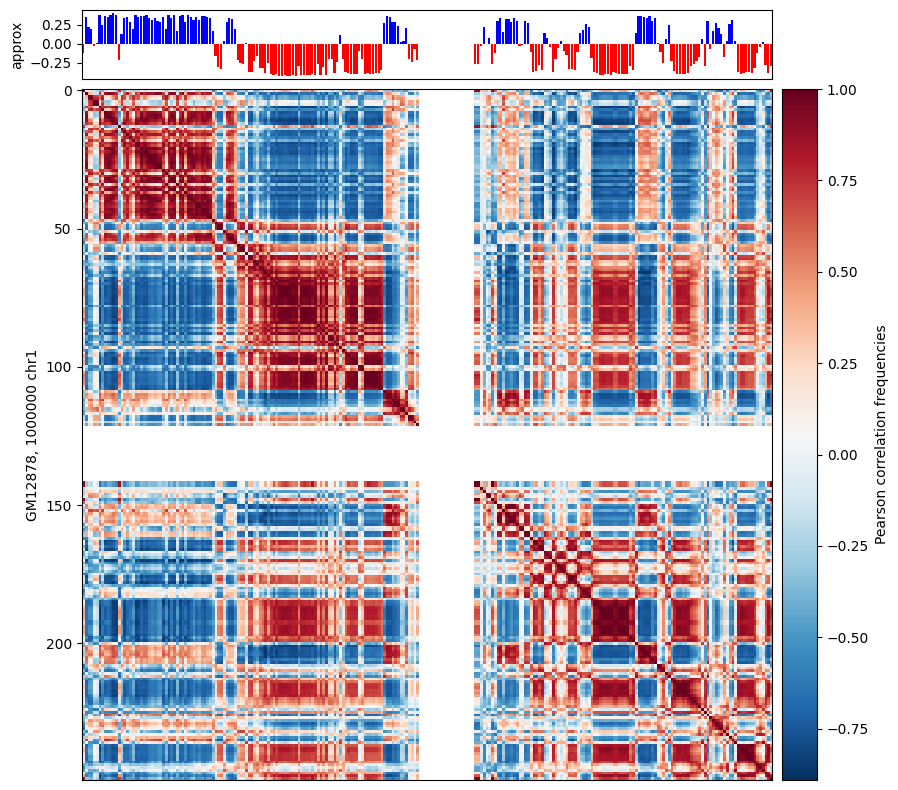

In [6]:
cell_line = "GM12878"
resolution = 1000000
chrom = "1"

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='Pearson correlation frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')
ax.xaxis.set_visible(False)

ax = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax.set_ylabel('approx')
ax.xaxis.set_visible(False)

#### Summary (1st part)

Here we summarize the main usage of HiCPAP:

1. Get the Hi-C Pearson matrix through the `paptools.read_pearson()` or `paptools.straw_to_pearson()` or create by yourself.
2. Create the Approximated PC1-pattern with `paptools.create_approx()`.

In [7]:
del f, im, ax

### 2. (Bonus) How to reproduce the experiments in our paper. 

In this section we explain how to create the figures for comparing the difference between the PC1 and the Approximated PC1-pattern using the scatter and the relative_magnitude plots.

1. Performing PCA on the Pearson matrix to get the first Principal component.

In [8]:
pearson_np = pearson_np.astype('float64')
diag = np.diag(pearson_np)
diag_valid = ~np.isnan(diag)
ixgrid = np.ix_(diag_valid, diag_valid) 
pca = PCA(n_components=1)
pca.fit(pearson_np[ixgrid])

# Fill back the NaN entries
pc1_np = np.full(len(diag_valid), np.nan)
pc1_np[diag_valid] = pca.components_[0]

print(pc1_np)

[-0.0241  0.0759  0.0487 ... -0.0633 -0.083  -0.0624]


2. Compare the similarity between the PC1 and the Approximated PC1-pattern.

In [9]:
# Compare the similarity between the HiCPAP calculated PC1 and the Approximated PC1-pattern.
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
similarity_info = paptools.calc_similarity(track1_np=pc1_np, track2_np=approx_np)
print(f"similarity_info: {similarity_info}")

similarity_info: {'total_entry_num': 250, 'valid_entry_num': 230, 'similar_num': 228, 'similar_rate': 0.991304347826087}


3. Save both the scatter and the relative_magnitude plots to the [outputs](https://github.com/ZhiRongDev/HiCPAP/blob/main/examples/outputs) directory.

In [10]:
paptools.plot_comparison(
    pc1_np=pc1_np,
    approx_np=approx_np,
    figsize=20,
    scatter="./outputs/gm12878_1000000_chr1_scatter.png",
    relative_magnitude="./outputs/gm12878_1000000_chr1_relative_magnitude.png"
)

4. Combined the Pearson matrix, PC1, Approximated PC1-pattern and the scatter plots for the comparison.

{'total_entry_num': 250, 'valid_entry_num': 230, 'similar_num': 228, 'similar_rate': 0.991304347826087}


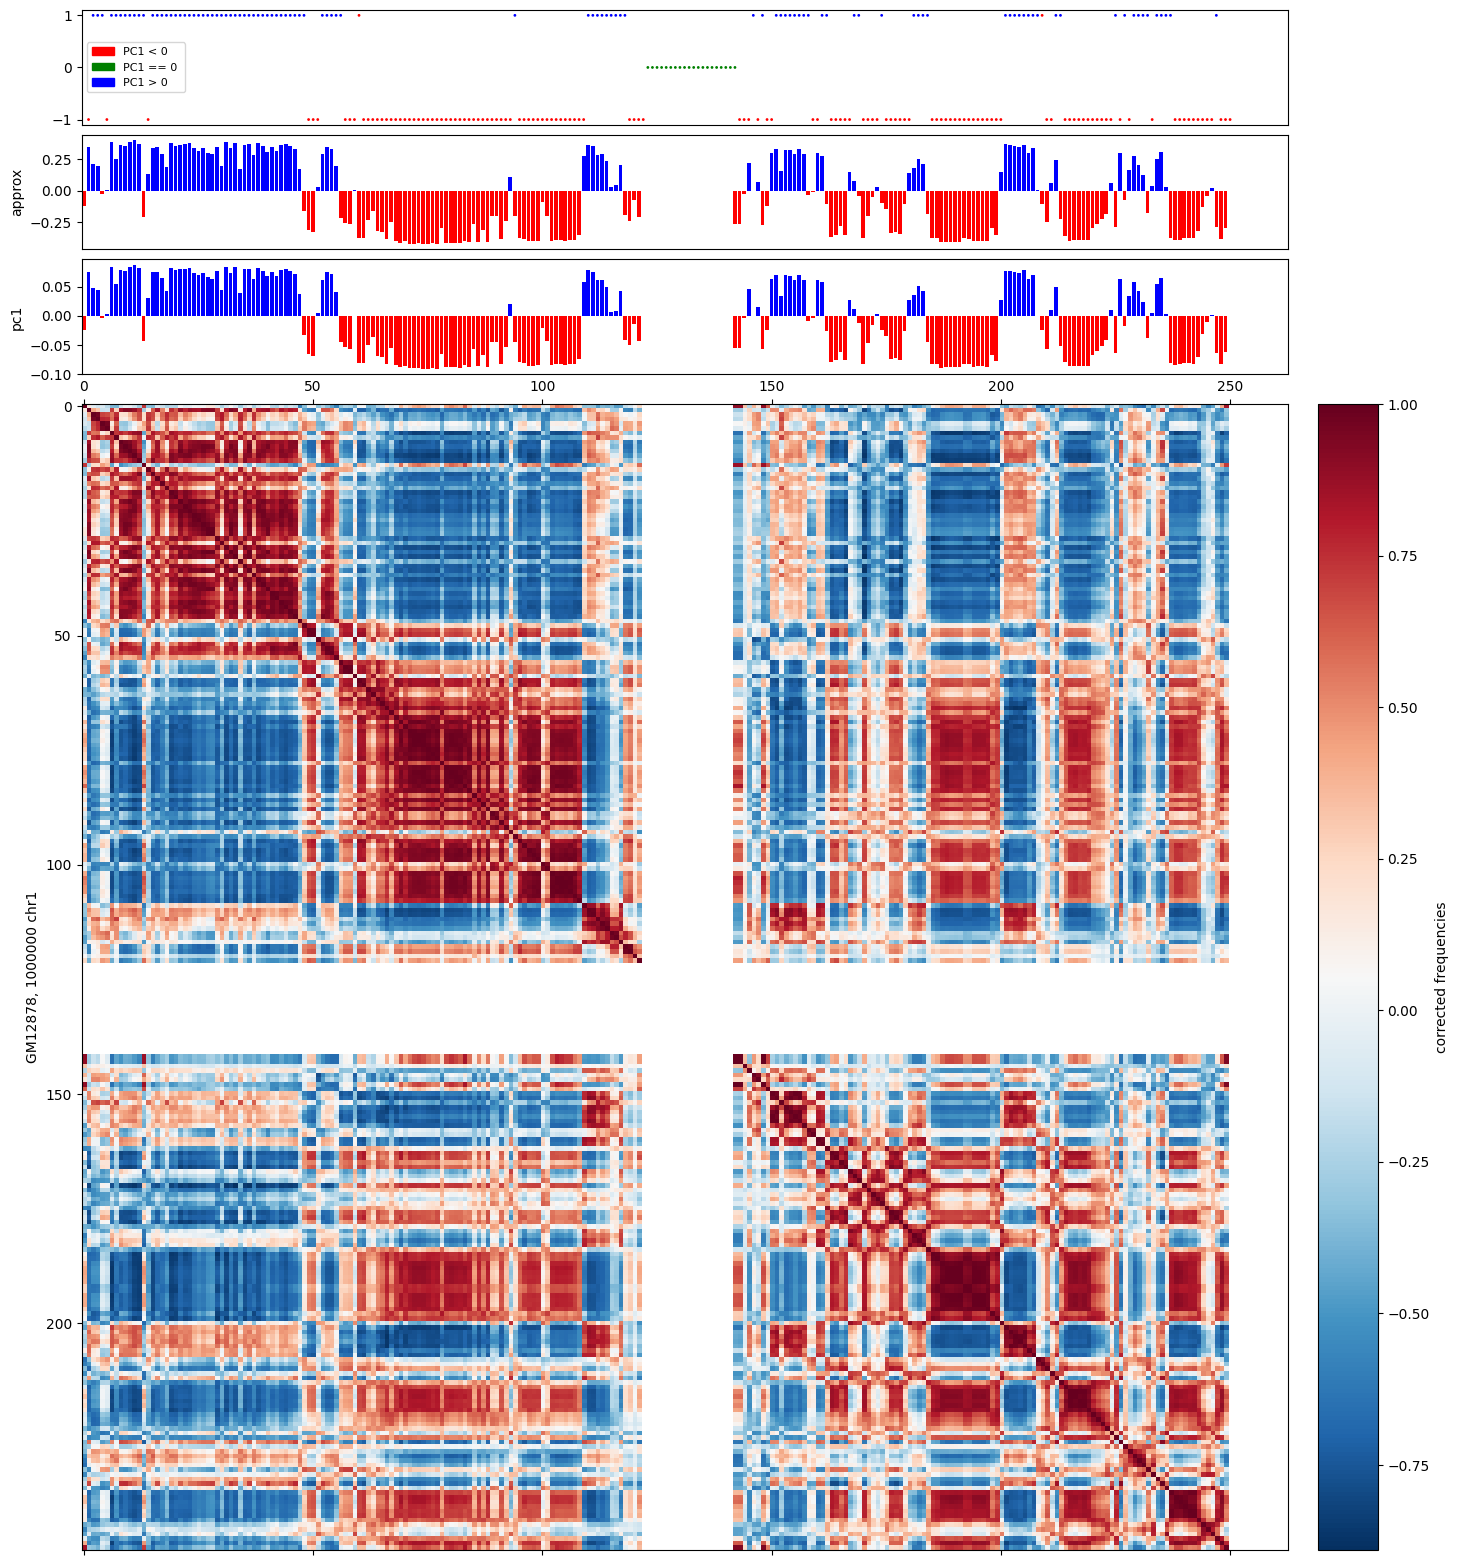

In [11]:
# Settings for pearson_np
f, ax = plt.subplots(
    figsize=(20, 20),
)
im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')

#### Settings for pc1_np (bar plot)
ax1 = divider.append_axes("top", size="10%", pad=0.3, sharex=ax)
pc1_x_axis = [i for i in range(0, len(pc1_np))]
pc1_bar_color = ['b' if i > 0 else 'r' for i in pc1_np]
ax1.bar(x=pc1_x_axis, height=pc1_np, color=pc1_bar_color)
ax1.set_ylabel('pc1')
ax1.xaxis.set_visible(False)

#### Settings for approx_np (bar plot)
ax2 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax2.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax2.set_ylabel('approx')
ax2.xaxis.set_visible(False)

#### Settings for pc1_np vs approx_np (scatter plot)
similarity_info = paptools.calc_similarity(track1_np=pc1_np, track2_np=approx_np)
total_entry_num = similarity_info["total_entry_num"]
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
pc1_colors_values = ['b' if i > 0 else 'r' if i < 0 else 'g' for i in pc1_np]
# https://matplotlib.org/stable/users/explain/axes/legend_guide.html
red_patch = mpatches.Patch(color='r', label='PC1 < 0 ')
green_patch = mpatches.Patch(color='g', label='PC1 == 0 ')
blue_patch = mpatches.Patch(color='b', label='PC1 > 0')
ax3 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
scatter_config = ax3.scatter(plot_x_axis, approx_dots, c=pc1_colors_values, s=1)
ax3.legend(handles=[red_patch, green_patch, blue_patch], fontsize="8", loc="center left")
ax3.xaxis.set_visible(False)

print(similarity_info)